In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

In [3]:
import cv2

In [4]:
video_ocr_paths = list(Path("../data/video_frame_obj").glob("*.csv"))

In [5]:
video_ocr_paths[:2]

[WindowsPath('../data/video_frame_obj/test_video_0.csv'),
 WindowsPath('../data/video_frame_obj/test_video_1.csv')]

In [6]:
diff_df_dict = dict()
for video_ocr_path in video_ocr_paths:
    file_name = video_ocr_path.name.split(".")[0]
    diff_df_dict[file_name] = pd.read_csv(video_ocr_path)

In [7]:
diff_df = diff_df_dict['test_video_13']
diff_df.head()

,index,dissimilarity,jaccard,jaccard_letter,frame_token_ct,lev_dis,word_dis,letter_dissim,min
0,1,0.073178,0.2,0.478261,4,0.368421,0.200000,0.157895,0.016667
1,2,0.036582,0.2,0.478261,5,0.187500,0.200000,0.157895,0.033333
2,3,0.073881,0.4,0.476190,4,0.062500,0.000000,0.000000,0.050000
3,4,0.194590,0.6,0.705882,4,1.666667,0.250000,0.625000,0.066667
4,5,1.000000,1.0,1.000000,3,6.000000,0.666667,1.000000,0.083333


In [8]:
import json
with open('labels.json', 'r') as file:
    labels = json.load(file)
labels.keys()

dict_keys(['test_video_0', 'test_video_1', 'test_video_10', 'test_video_11', 'test_video_12'])

In [9]:
def create_label_function(labels:list):
    return lambda index_ : True if index_ in labels else False

In [10]:
create_label_function(labels['test_video_0'])(3467)

True

## load ocr results

In [11]:
video_ocr_result_paths = list(Path("../data/video_ocr_results").glob("*.json"))

ocr_dict = dict()
for video_ocr_path in video_ocr_result_paths:
    file_name = video_ocr_path.name.split(".")[0]
    
    print(video_ocr_path)
    with open(video_ocr_path.absolute(), 'r') as file:
        test_ocr_results = json.load(file)
        
    ocr_dict[file_name] = test_ocr_results 

..\data\video_ocr_results\test_video_0.json
..\data\video_ocr_results\test_video_1.json
..\data\video_ocr_results\test_video_10.json
..\data\video_ocr_results\test_video_11.json
..\data\video_ocr_results\test_video_12.json
..\data\video_ocr_results\test_video_13.json
..\data\video_ocr_results\test_video_14.json
..\data\video_ocr_results\test_video_15.json
..\data\video_ocr_results\test_video_16.json
..\data\video_ocr_results\test_video_17.json
..\data\video_ocr_results\test_video_18.json
..\data\video_ocr_results\test_video_19.json
..\data\video_ocr_results\test_video_2.json
..\data\video_ocr_results\test_video_20.json
..\data\video_ocr_results\test_video_3.json
..\data\video_ocr_results\test_video_4.json
..\data\video_ocr_results\test_video_5.json
..\data\video_ocr_results\test_video_6.json
..\data\video_ocr_results\test_video_7.json
..\data\video_ocr_results\test_video_8.json
..\data\video_ocr_results\test_video_9.json


## training model

In [12]:
train_df = pd.DataFrame()
train_df_lst = []
for video_name, label_frames in labels.items():
    diff_df = diff_df_dict[video_name].iloc[2:,].copy() #remove the first 2 frames
    diff_df['video_index'] = diff_df['index']
    
    label_function = create_label_function(label_frames)
    diff_df['new_slide'] = diff_df['index'].apply(label_function)
    diff_df['video_name'] = video_name
    train_df_lst.append(diff_df)
    

In [13]:
pd.concat(train_df_lst)['new_slide'].sum(), pd.concat(train_df_lst)['new_slide'].mean()

(166, 0.009885071160602632)

In [14]:
train_df = pd.concat(train_df_lst, ignore_index=True)
# not use nlp's dissimilarity
train_df['dissimilarity'] = train_df['jaccard']
#train_df = train_df.drop(['lev_dis', 'index'], axis=1)

train_df = train_df.drop([ 'index', 'min'], axis=1)
train_df.head()

,dissimilarity,jaccard,jaccard_letter,frame_token_ct,lev_dis,word_dis,letter_dissim,video_index,new_slide,video_name
0,0.000000,0.000000,0.720000,4,0.000000,0.000000,0.000000,3,False,test_video_0
1,0.000000,0.000000,0.720000,4,0.000000,0.000000,0.000000,4,False,test_video_0
2,0.954545,0.954545,0.855670,4,0.797468,0.789474,0.594937,5,True,test_video_0
3,0.272727,0.272727,0.890459,19,0.102564,0.000000,0.012658,6,False,test_video_0
4,0.304348,0.304348,0.892361,19,0.110429,0.050000,0.042945,7,False,test_video_0


In [15]:
train_df.columns

Index(['dissimilarity', 'jaccard', 'jaccard_letter', 'frame_token_ct',
       'lev_dis', 'word_dis', 'letter_dissim', 'video_index', 'new_slide',
       'video_name'],
      dtype='object')

In [16]:
feature_names = ['jaccard', 'jaccard_letter', 'frame_token_ct',
       'word_dis', 'letter_dissim']
#'dissimilarity', 

In [17]:
train_df['video_name']

0         test_video_0
1         test_video_0
2         test_video_0
3         test_video_0
4         test_video_0
             ...      
16788    test_video_12
16789    test_video_12
16790    test_video_12
16791    test_video_12
16792    test_video_12
Name: video_name, Length: 16793, dtype: object

In [18]:
X = train_df.query("video_name!='test_video_12'")[feature_names].fillna(0)
y = train_df.query("video_name!='test_video_12'")['new_slide']

In [19]:
x_test = train_df.query("video_name=='test_video_12'")[feature_names].fillna(0)
y_test = train_df.query("video_name=='test_video_12'")['new_slide']

In [20]:
from sklearn.datasets import load_iris
from sklearn import tree
seed =12345
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=seed)
clf = clf.fit(X, y)

dummy_clf = tree.DecisionTreeClassifier(max_depth=2, random_state=seed)
dummy_clf  = dummy_clf.fit(X, y)


In [21]:
y_pred = clf.predict(X)
dummy_y_pred = dummy_clf.predict(X)
my_dummy_y_pred = X['jaccard']   >= 0.1
y_true = y


# keep probabilities for the positive outcome only
from sklearn.metrics import precision_recall_curve
lr_probs = clf.predict_proba(X)
lr_probs = lr_probs[:, 1]
# predict class values
y_pred = clf.predict(X)
# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(y_true, lr_probs)

## model export

In [22]:
from joblib import dump, load
dump(clf, '../models/ocr_tree.joblib') 

['../models/ocr_tree.joblib']

In [23]:
MODEL_PATH = '../models/ocr_tree.joblib'
clf = load(MODEL_PATH) 

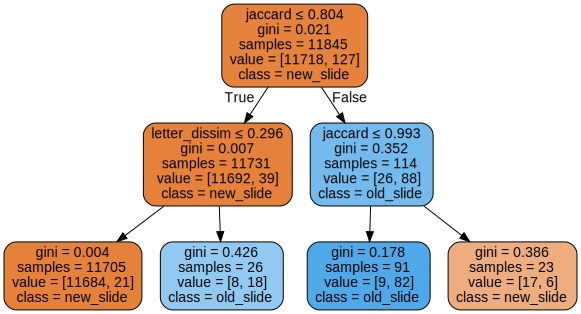

In [25]:
dot_data = tree.export_graphviz(dummy_clf, out_file=None, 
                      feature_names=feature_names,  
                      class_names=['new_slide', 'old_slide'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

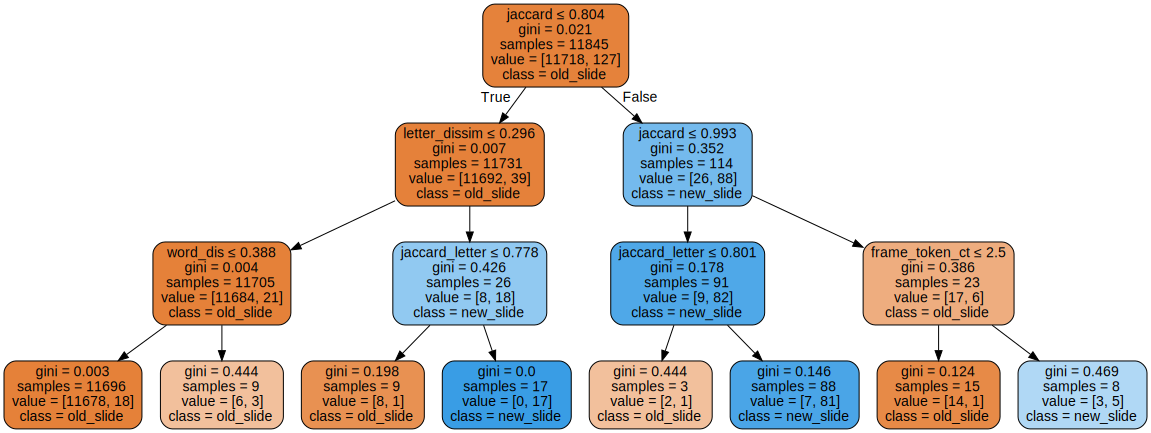

In [26]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=feature_names,  
                      class_names=['old_slide', 'new_slide'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [27]:
import pydot

(graph,) = pydot.graph_from_dot_data(dot_data)
graph.write_png('somefile.png')

In [28]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     11718
        True       0.91      0.81      0.86       127

    accuracy                           1.00     11845
   macro avg       0.95      0.91      0.93     11845
weighted avg       1.00      1.00      1.00     11845



In [29]:
confusion_matrix(y_true, y_pred)

array([[11708,    10],
       [   24,   103]], dtype=int64)

In [30]:
##### 
confusion_matrix(y_true, dummy_y_pred) #missed 25, 43 

array([[11701,    17],
       [   27,   100]], dtype=int64)

In [31]:
cm = confusion_matrix(y_true, my_dummy_y_pred)
cm

array([[2226, 9492],
       [   3,  124]], dtype=int64)

In [32]:
# testing on video12
y_test_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[4909,    0],
       [   1,   38]], dtype=int64)